<a href="https://colab.research.google.com/github/mum-courses/EA_cluster/blob/master/Neural_Networks_for_Collaborative_Filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# orginally from: https://colab.research.google.com/github/nipunbatra/blog/blob/master/_notebooks/2017-12-29-neural-collaborative-filtering.ipynb#scrollTo=-IL00kXcLI3M

In [ ]:
!pip install surprise
!pip install plot_keras_history

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [ ]:
from surprise import Dataset
surprise_dataset = Dataset.load_builtin('ml-100k')
data=pd.DataFrame(surprise_dataset.raw_ratings, columns =['userId', 'itemId', 'rating','timestamp'])
data=data.drop(columns=['timestamp'])
data.userId = data.userId.astype('category').cat.codes.values
data.itemId = data.itemId.astype('category').cat.codes.values
data.head()


,userId,itemId,rating
0,107,842,3.0
1,96,909,3.0
2,134,991,1.0
3,161,1139,2.0
4,74,957,1.0


In [ ]:
X=data.loc[:,['userId','itemId']]
y=data.loc[:,'rating']

from sklearn.model_selection import train_test_split
train,test = train_test_split(data, test_size=0.2, random_state=42)


#SVD

In [ ]:
from surprise import SVD
from surprise import accuracy
from surprise.model_selection import train_test_split
algo = SVD()
trainset, testset = train_test_split(surprise_dataset, test_size=.2)
algo.fit(trainset)

predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 0.9282


0.9282000806330497

#Neural Netwrok

In [ ]:
#common code

#input: [test.userId,test.itemId] , y:test.rating
def evalModel(model,input,y):
  from sklearn.metrics import mean_squared_error
  return mean_squared_error(y, model.predict(input))

def plotHistory(history):
  from plot_keras_history import plot_history
  import matplotlib.pyplot as plt

  plot_history(history)
  plt.show()
  plt.close()
def visualizeModel(model):
  from IPython.display import SVG
  from keras.utils.vis_utils import model_to_dot
  print(model.summary())
  
  return SVG(model_to_dot(model,  show_shapes=False, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))


def trainNN(model):
  model.compile(optimizer='adam',loss= 'mean_squared_error')

  earlyStopping=tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
  history = model.fit([train.userId, train.itemId], train.rating, epochs=100, verbose=1
                      ,batch_size=100
                    ,callbacks=[earlyStopping],
                    validation_split=0.1)
  plotHistory(history)
  score=evalModel(model,[test.userId,test.itemId],test.rating)
  print(f"test MSE: {score}")
  return history,model


## concat

In [ ]:
def buildConcatModel():
  import tensorflow as tf
  from tensorflow import keras
  from tensorflow.keras import layers

  n_latent_factors_user = 100
  n_latent_factors_movie = 100
  n_users, n_movies = len(data.userId.unique()), len(data.itemId.unique())

  movie_input = keras.layers.Input(shape=[1],name='Item')
  movie_embedding_mlp = keras.layers.Embedding(n_movies + 1, n_latent_factors_movie, name='Movie-Embedding-MLP')(movie_input)
  movie_vec_mlp = keras.layers.Flatten(name='FlattenMovies-MLP')(movie_embedding_mlp)
  movie_vec_mlp = keras.layers.Dropout(0.2)(movie_vec_mlp)



  user_input = keras.layers.Input(shape=[1],name='User')
  user_vec_mlp = keras.layers.Flatten(name='FlattenUsers-MLP')(keras.layers.Embedding(n_users + 1, n_latent_factors_user,name='User-Embedding-MLP')(user_input))
  user_vec_mlp = keras.layers.Dropout(0.2)(user_vec_mlp)

  concat=tf.keras.layers.Concatenate()([movie_vec_mlp, user_vec_mlp])
  concat_dropout = keras.layers.Dropout(0.2)(concat)

  dense = keras.layers.Dense(200,name='FullyConnected')(concat_dropout)
  dense_batch = keras.layers.BatchNormalization(name='Batch')(dense)
  dropout_1 = keras.layers.Dropout(0.2,name='Dropout-1')(dense_batch)

  dense_2 = keras.layers.Dense(100,name='FullyConnected-1')(dropout_1)
  dense_batch_2 = keras.layers.BatchNormalization(name='Batch-2')(dense_2)
  dropout_2 = keras.layers.Dropout(0.2,name='Dropout-2')(dense_batch_2)

  dense_3 = keras.layers.Dense(50,name='FullyConnected-2')(dropout_2)

  dense_4 = keras.layers.Dense(20,name='FullyConnected-2')(dropout_2)

  result = keras.layers.Dense(1, activation='relu',name='Prediction')(dense_4)


  model = keras.Model([user_input, movie_input], result)
 
  return model

Epoch 1/100
720/720 [==============================] - 8s 9ms/step - loss: 2.3404 - val_loss: 0.9698
Epoch 2/100
720/720 [==============================] - 6s 9ms/step - loss: 0.9934 - val_loss: 0.9236
Epoch 3/100
720/720 [==============================] - 6s 9ms/step - loss: 0.9388 - val_loss: 0.9257
Epoch 4/100
720/720 [==============================] - 7s 9ms/step - loss: 0.9201 - val_loss: 0.9509
Epoch 5/100
720/720 [==============================] - 6s 9ms/step - loss: 0.9093 - val_loss: 0.9126
Epoch 6/100
720/720 [==============================] - 6s 9ms/step - loss: 0.9055 - val_loss: 0.9135
Epoch 7/100
720/720 [==============================] - 6s 9ms/step - loss: 0.8968 - val_loss: 0.9408
Epoch 8/100
720/720 [==============================] - 7s 9ms/step - loss: 0.8953 - val_loss: 0.9244
Epoch 9/100
720/720 [==============================] - 7s 9ms/step - loss: 0.8891 - val_loss: 0.9120
Epoch 10/100
720/720 [==============================] - 6s 9ms/step - loss: 0.8880 - val_lo

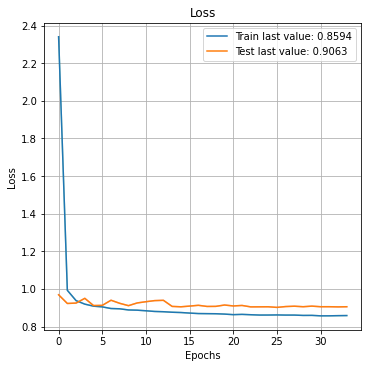

test MSE: 0.8927092305626022


In [117]:
history,model = trainNN(buildConcatModel())

## Dot product

In [ ]:
def buildDotModel():
  import tensorflow as tf
  from tensorflow import keras
  from tensorflow.keras import layers

  n_latent_factors_user = 50
  n_latent_factors_movie = 50
  n_users, n_movies = len(data.userId.unique()), len(data.itemId.unique())

  movie_input = keras.layers.Input(shape=[1],name='Item')
  movie_embedding_mlp = keras.layers.Embedding(n_movies + 1, n_latent_factors_movie, name='Movie-Embedding-MLP')(movie_input)
  movie_vec_mlp = keras.layers.Flatten(name='FlattenMovies-MLP')(movie_embedding_mlp)
  movie_vec_mlp = keras.layers.Dropout(0.2)(movie_vec_mlp)



  user_input = keras.layers.Input(shape=[1],name='User')
  user_vec_mlp = keras.layers.Flatten(name='FlattenUsers-MLP')(keras.layers.Embedding(n_users + 1, n_latent_factors_user,name='User-Embedding-MLP')(user_input))
  user_vec_mlp = keras.layers.Dropout(0.2)(user_vec_mlp)

  #dot product to create cosine similiarity
  concat=tf.keras.layers.Dot(axes=1)([movie_vec_mlp, user_vec_mlp])
  concat_dropout = keras.layers.Dropout(0.2)(concat)

  dense = keras.layers.Dense(100,name='FullyConnected')(concat_dropout)
  dense_batch = keras.layers.BatchNormalization(name='Batch')(dense)
  dropout_1 = keras.layers.Dropout(0.2,name='Dropout-1')(dense_batch)

  dense_2 = keras.layers.Dense(50,name='FullyConnected-1')(dropout_1)
  dense_batch_2 = keras.layers.BatchNormalization(name='Batch-2')(dense_2)
  dropout_2 = keras.layers.Dropout(0.2,name='Dropout-2')(dense_batch_2)

  dense_3 = keras.layers.Dense(20,name='FullyConnected-2')(dropout_2)

  pred_mlp = keras.layers.Dense(1, activation='relu',name='Activation')(dense_3)

  result = keras.layers.Dense(1,name='Prediction')(pred_mlp)


  model = keras.Model([user_input, movie_input], result)
  opt = keras.optimizers.Adam(lr =0.01)
  model.compile(optimizer='adam',loss= 'mean_squared_error')
  return model

In [ ]:
history,model = trainNN(buildDotModel())

## Combined (NCF paper)

In [ ]:
def buildCombinedNCFModel():
  import tensorflow as tf
  from tensorflow import keras
  from tensorflow.keras import layers

  n_latent_factors_user = 128
  n_latent_factors_movie = 128
  n_latent_factors_mf = 128
  n_users, n_movies = len(data.userId.unique()), len(data.itemId.unique())

  movie_input = keras.layers.Input(shape=[1],name='Item')
  movie_embedding_mlp = keras.layers.Embedding(n_movies + 1, n_latent_factors_movie, name='Movie-Embedding-MLP')(movie_input)
  movie_vec_mlp = keras.layers.Flatten(name='FlattenMovies-MLP')(movie_embedding_mlp)
  movie_vec_mlp = keras.layers.Dropout(0.2)(movie_vec_mlp)

  movie_embedding_mf = keras.layers.Embedding(n_movies + 1, n_latent_factors_mf, name='Movie-Embedding-MF')(movie_input)
  movie_vec_mf = keras.layers.Flatten(name='FlattenMovies-MF')(movie_embedding_mf)
  movie_vec_mf = keras.layers.Dropout(0.2)(movie_vec_mf)


  user_input = keras.layers.Input(shape=[1],name='User')
  user_vec_mlp = keras.layers.Flatten(name='FlattenUsers-MLP')(keras.layers.Embedding(n_users + 1, n_latent_factors_user,name='User-Embedding-MLP')(user_input))
  user_vec_mlp = keras.layers.Dropout(0.2)(user_vec_mlp)

  user_vec_mf = keras.layers.Flatten(name='FlattenUsers-MF')(keras.layers.Embedding(n_users + 1, n_latent_factors_mf,name='User-Embedding-MF')(user_input))
  user_vec_mf = keras.layers.Dropout(0.2)(user_vec_mf)


  #concat = keras.layers.merge([movie_vec_mlp, user_vec_mlp], mode='concat',name='Concat')
  concat=tf.keras.layers.Concatenate()([movie_vec_mlp, user_vec_mlp])
  concat_dropout = keras.layers.Dropout(0.2)(concat)
  dense = keras.layers.Dense(200,name='FullyConnected')(concat_dropout)
  dense_batch = keras.layers.BatchNormalization(name='Batch')(dense)
  dropout_1 = keras.layers.Dropout(0.2,name='Dropout-1')(dense_batch)
  dense_2 = keras.layers.Dense(100,name='FullyConnected-1')(dropout_1)
  dense_batch_2 = keras.layers.BatchNormalization(name='Batch-2')(dense_2)


  dropout_2 = keras.layers.Dropout(0.2,name='Dropout-2')(dense_batch_2)
  dense_3 = keras.layers.Dense(50,name='FullyConnected-2')(dropout_2)
  dense_4 = keras.layers.Dense(20,name='FullyConnected-3', activation='relu')(dense_3)

  #pred_mf = keras.layers.merge([movie_vec_mf, user_vec_mf], mode='dot',name='Dot')
  pred_mf = tf.keras.layers.Dot(axes=1,name="pred_mf")([movie_vec_mf, user_vec_mf])

  pred_mlp = keras.layers.Dense(1, activation='relu',name='Activation')(dense_4)

  #combine_mlp_mf = keras.layers.merge([pred_mf, pred_mlp], mode='concat',name='Concat-MF-MLP')
  combine_mlp_mf=tf.keras.layers.Concatenate(name="Concat-MF-MLP")([pred_mf, pred_mlp])
  result_combine = keras.layers.Dense(100,name='Combine-MF-MLP')(combine_mlp_mf)
  deep_combine = keras.layers.Dense(100,name='FullyConnected-4')(result_combine)


  result = keras.layers.Dense(1,name='Prediction')(deep_combine)


  model = keras.Model([user_input, movie_input], result)
  return model

In [ ]:
history,model = trainNN(buildCombinedNCFModel())

Epoch 1/100
720/720 [==============================] - 12s 15ms/step - loss: 1.5253 - val_loss: 1.0170
Epoch 2/100
720/720 [==============================] - 11s 15ms/step - loss: 0.7751 - val_loss: 0.9907
Epoch 3/100
720/720 [==============================] - 11s 15ms/step - loss: 0.4449 - val_loss: 1.0109
Epoch 4/100
720/720 [==============================] - 11s 15ms/step - loss: 0.3519 - val_loss: 1.0088
Epoch 5/100
720/720 [==============================] - 11s 15ms/step - loss: 0.3110 - val_loss: 1.0294
Epoch 6/100
720/720 [==============================] - 11s 15ms/step - loss: 0.2878 - val_loss: 1.0163
Epoch 7/100
720/720 [==============================] - 11s 15ms/step - loss: 0.2696 - val_loss: 1.0043
Epoch 8/100
720/720 [==============================] - 11s 15ms/step - loss: 0.2608 - val_loss: 1.0341
Epoch 9/100
720/720 [==============================] - 11s 15ms/step - loss: 0.2524 - val_loss: 1.0208
Epoch 10/100
720/720 [==============================] - 11s 15ms/step - l

KeyboardInterrupt: ignored

In [ ]:
visualizeModel(model)

In [ ]:
#export model
 model.save("ncf")